In [12]:
#Data 
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt

M = 10000 #Amount of iterations

t_f = 25              #years       
M_costDiesel = 800000 #SEK/year
M_costHybrid = 700000 #SEK/year   
D_cost = 9            #SEK/liter                   
                    
P_cons = np.random.triangular(80, 110, 140, M)     #kWh/hour
D_cons = np.random.triangular(25, 35, 45, M)       #liter/hour
t_b = np.random.triangular(8, 10, 12, M)           #years
E_cost = np.random.triangular(1.30, 2, 2.45, M)    #SEK/kWh
B_cost = np.random.triangular(2000, 4000, 6000, M) #SEK/kWh installed
F_costDiesel = np.random.triangular(60 * pow(10,6), 62 * pow(10,6), 65 * pow(10,6), M) 
F_cost1260 = np.random.triangular(75 * pow(10,6), 77.5 * pow(10,6), 80 * pow(10,6), M)
F_cost1000 = F_cost1260 - (260 * B_cost)
F_costRetrofit = np.random.triangular(20 * pow(10,6), 22.5 * pow(10,6), 25 * pow(10,6), M)
P_cost = np.random.triangular(1000, 3000, 3000, M) #SEK/kW, plug-in charger
W_cost = np.random.triangular(1600, 4500, 4500, M) #SEK/kw, wirelss charger

#CRF
i = 0.03
n = t_f
CRF = (i*pow(1+i,n))/(pow(1+i,n)-1)
print(CRF)

#Depreciation formula
r = 0.073
N = 10

F_costNew130 = F_cost1260 + B_cost * (130 - 1260)
F_costNew630 = F_cost1260 + B_cost * (630 - 1260)

F_costRetrofit670 = np.zeros(M)
F_costRetrofit1260 = np.zeros(M) 
                              
for i in range(M):
    F_costRetrofit670[i] = (F_costDiesel[i]*pow(1-r,N) + F_costRetrofit[i]) - (1260 * B_cost[i]) + (670 * B_cost[i])
    F_costRetrofit1260[i] = (F_costDiesel[i]*pow(1-r,N) + F_costRetrofit[i]) - (1260 * B_cost[i]) + (1260 * B_cost[i])

0.05742787103912777


In [13]:
#Acquisition cost:
def aCalc(F_cost1,F_cost2,F_cost3,F_cost4):
    C_a1 = (F_cost1 * CRF) / 365
    C_a2 = (F_cost2 * CRF) / 365
    C_a3 = (F_cost3 * CRF) / 365
    C_a4 = (F_cost4 * CRF) / 365
    a = [C_a1, C_a2, C_a3, C_a4]
    C_a = np.sum(a, axis=0)
    return C_a
#Infrastructure cost:
def iCalc(P,W_s,W_f,P_char,W_char): #P = plug-in, W_s = stationary wireless, W_f = on-board wireless
    C_i = (((P * P_char * P_cost) + (W_s * W_char * W_cost * 0.6) + (W_f * W_char * W_cost * 0.4)) * CRF) / 365
    #print(C_i)
    return C_i
#Battery replacement cost:
def rCalc(kw1,kw2,kw3,kw4):
    C_r1 = (((t_f / t_b) * (B_cost * kw1)) * CRF) / 365
    C_r2 = (((t_f / t_b) * (B_cost * kw2)) * CRF) / 365
    C_r3 = (((t_f / t_b) * (B_cost * kw3)) * CRF) / 365
    C_r4 = (((t_f / t_b) * (B_cost * kw4)) * CRF) / 365
    r = [C_r1, C_r2, C_r3, C_r4]
    C_r = np.sum(r, axis=0)
    #print(C_r)
    return C_r
#Maintenance cost:
def mCalc(M_cost1,M_cost2,M_cost3,M_cost4):
    C_m1 = M_cost1 / 365
    C_m2 = M_cost2 / 365
    C_m3 = M_cost3 / 365
    C_m4 = M_cost4 / 365
    
    m = C_m1 + C_m2 + C_m3 + C_m4
    C_m = [m] * M
    #print(C_m)
    return C_m
#Fuel cost:
def fCalc(t_op1,t_op2,t_op3,t_op4,e_f1,e_f2,e_f3,e_f4):
    C_f1 = (P_cons * E_cost * e_f1 * t_op1) + (D_cons * D_cost * (1-e_f1)*t_op1)
    C_f2 = (P_cons * E_cost * e_f2 * t_op2) + (D_cons * D_cost * (1-e_f2)*t_op2)
    C_f3 = (P_cons * E_cost * e_f3 * t_op3) + (D_cons * D_cost * (1-e_f3)*t_op3)
    C_f4 = (P_cons * E_cost * e_f4 * t_op4) + (D_cons * D_cost * (1-e_f4)*t_op4)
    f = [C_f1, C_f2, C_f3, C_f4]
    C_f = np.sum(f, axis=0)
    #print(C_f)
    return C_f
#Total cost:
def totCalc(C_a,C_i,C_r,C_m,C_f):
    x = [C_a, C_i, C_r, C_m, C_f]
    C_tot = np.sum(x, axis=0)
    #print(C_tot)
    return C_tot
#Operational costs:
def opexCalc(C_tot,C_a,C_i):
    #print(C_tot - (C_a + C_i))
    return C_tot - (C_a + C_i)

def summary(C_a,C_i,C_r,C_m,C_f,C_tot,C_opex):
    print('COST SUMMARY [SEK / DAY]')
    print('')
    print('Acquisition cost: ' + str(C_a))
    print('Infrastructure cost: ' + str(C_i))
    print('Battery replacement cost: ' + str(C_r))
    print('Maintenance cost: ' + str(C_m))
    print('Fuel cost: ' + str(C_f))
    print('Total scenario cost: ' +str(C_tot))
    print('Total Opex: ' +str(C_opex))

[62797.64979178 66882.49001868]


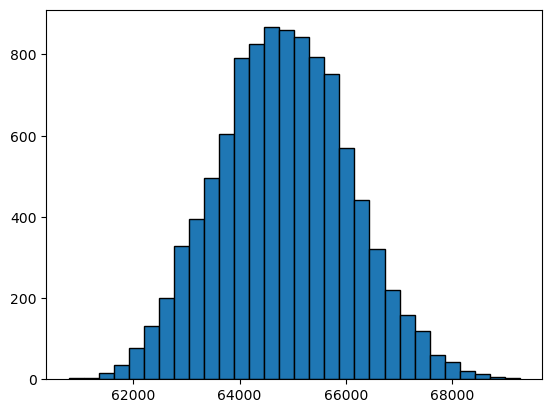

In [14]:
#BASELINE

t_op1 = 13       #[hour], the range is 10-13 hours. 13 is max since the ferries run from 06:00 to 19:00
t_op2 = 12.5
t_op3 = 8 
t_op4 = 0

e_f1 = 0.6154
e_f2 = 0.5200
e_f3 = 0
e_f4 = 0

f1_kw = 1260
f2_kw = 1000
f3_kw = 0
f4_kw = 0

P = 2
W_s = 0
W_f = 0
P_char = 200
W_char = 0

C_a = aCalc(F_cost1260,F_cost1000,F_costDiesel,F_costDiesel)
C_i = iCalc(P,W_s,W_f,P_char,W_char)
C_r = rCalc(f1_kw,f2_kw,f3_kw,f4_kw)
C_m = mCalc(M_costHybrid,M_costHybrid,M_costDiesel,M_costDiesel)
C_f = fCalc(t_op1,t_op2,t_op3,t_op4,e_f1,e_f2,e_f3,e_f4)
C_tot = totCalc(C_a,C_i,C_r,C_m,C_f)

plt.hist(C_tot, bins = 30, ec = 'black')
p = np.percentile(C_tot, [5, 95])
print(p)


[59777.29154395 66572.89289499]


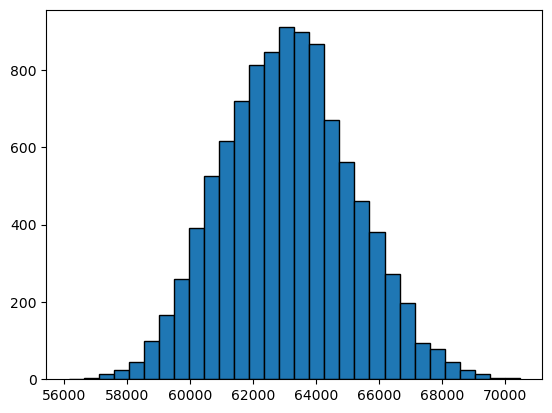

In [15]:
#BB

t_op1 = 11     
t_op2 = 10.5
t_op3 = 9
t_op4 = 3

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

f1_kw = 1260
f2_kw = 1000
f3_kw = 1260
f4_kw = 1260

P = 4
W_s = 0
W_f = 0
P_char = 200
W_char = 0

C_a = aCalc(F_cost1260,F_cost1000,F_costRetrofit1260,F_costRetrofit1260)
C_i = iCalc(P,W_s,W_f,P_char,W_char)
C_r = bCalc(f1_kw,f2_kw,f3_kw,f4_kw)
C_m = mCalc(M_costHybrid,M_costHybrid,M_costHybrid,M_costHybrid)
C_f = fCalc(t_op1,t_op2,t_op3,t_op4,e_f1,e_f2,e_f3,e_f4)
C_tot = totCalc(C_a,C_i,C_r,C_m,C_f)

plt.hist(C_tot, bins = 30, ec = 'black')
p = np.percentile(C_tot, [5, 95])
print(p)



[56654.06442756 61537.1512752 ]


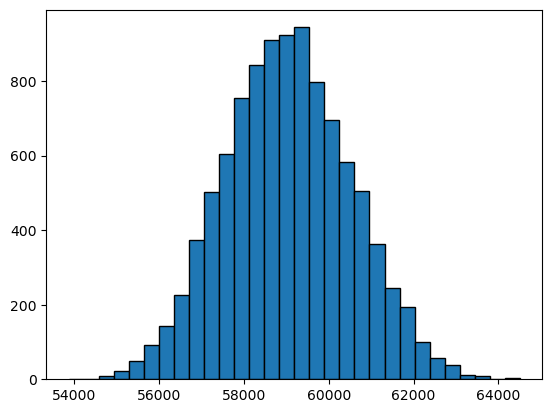

In [16]:
#OBS

t_op1 = 8       
t_op2 = 8.5
t_op3 = 9 
t_op4 = 8

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

f1_kw = 670
f2_kw = 670
f3_kw = 670
f4_kw = 670

P = 4
W_s = 0
W_f = 0
P_char = 200
W_char = 0

C_a = aCalc(F_cost1260,F_cost1000,F_costRetrofit670,F_costRetrofit670)
C_i = iCalc(P,W_s,W_f,P_char,W_char)
C_r = bCalc(f1_kw,f2_kw,f3_kw,f4_kw)
C_m = mCalc(M_costHybrid,M_costHybrid,M_costHybrid,M_costHybrid)
C_f = fCalc(t_op1,t_op2,t_op3,t_op4,e_f1,e_f2,e_f3,e_f4)
C_tot = totCalc(C_a,C_i,C_r,C_m,C_f)

plt.hist(C_tot, bins = 30, ec = 'black')
p = np.percentile(C_tot, [5, 95])
print(p)


[60318.81868636 65001.67631017]


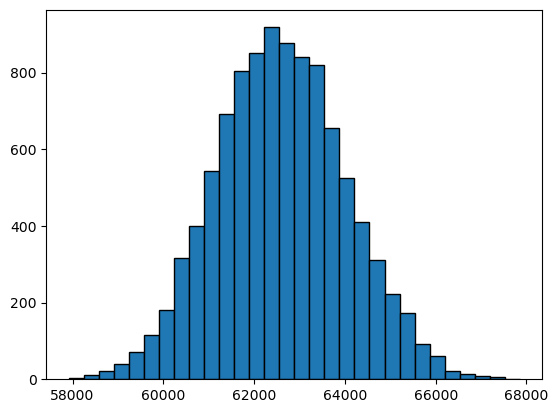

In [17]:
#WS

t_op1 = 8.375       
t_op2 = 8.375  
t_op3 = 8.375  
t_op4 = 8.375  

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

f1_kw = 130
f2_kw = 130
f3_kw = 130
f4_kw = 130

S = 0
W_s = 2
W_f = 4
P_char = 0
W_char = 700

C_a = aCalc(F_costNew130,F_costNew130,F_costNew130,F_costNew130)
C_i = iCalc(S,W_s,W_f,P_char,W_char)
C_r = bCalc(f1_kw,f2_kw,f3_kw,f4_kw)
C_m = mCalc(M_costHybrid,M_costHybrid,M_costHybrid,M_costHybrid)
C_f = fCalc(t_op1,t_op2,t_op3,t_op4,e_f1,e_f2,e_f3,e_f4)
C_tot = totCalc(C_a,C_i,C_r,C_m,C_f)

plt.hist(C_tot, bins = 30, ec = 'black')
p = np.percentile(C_tot, [5, 95])
print(p)


[64335.70366337 69183.2025315 ]


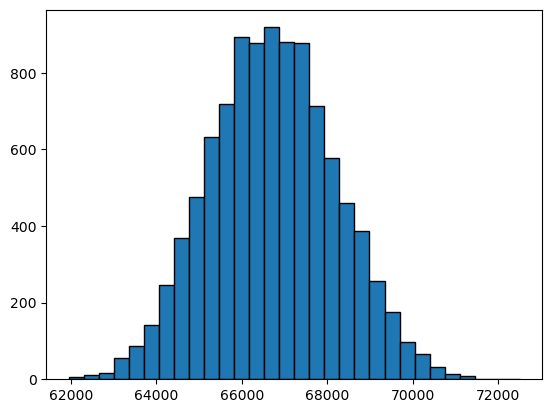

In [18]:
#WF

t_op1 = 8.375       
t_op2 = 8.375  
t_op3 = 8.375  
t_op4 = 8.375  

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

f1_kw = 630
f2_kw = 630
f3_kw = 630
f4_kw = 630

W_s470 = 2
W_s50 = 4
W_f = 4
P_char = 0

C_i = (((W_s470 * 470 * W_cost * 0.6) + (W_s50 * 50 * W_cost * 0.6) + (W_f * 470 * W_cost * 0.4)) * CRF) / 365

C_a = aCalc(F_costNew630,F_costNew630,F_costNew630,F_costNew630)
C_r = rCalc(f1_kw,f2_kw,f3_kw,f4_kw)
C_m = mCalc(M_costHybrid,M_costHybrid,M_costHybrid,M_costHybrid)
C_f = fCalc(t_op1,t_op2,t_op3,t_op4,e_f1,e_f2,e_f3,e_f4)
C_tot = totCalc(C_a,C_i,C_r,C_m,C_f)

plt.hist(C_tot, bins = 30, ec = 'black')
p = np.percentile(C_tot, [5, 95])
print(p)